****MScFE Capstone Project****

Student Group 7115
1. Azeez Adekunle Adebayo (azeezadebayo39@gmail.com)
2. Daniel Eseoghene Karakitie (dkarakitie@gmail.com)
3. Fatahi Abiodun Musa (musafatahi3@gmail.com)

**Title: Energy Products Relationship in Different Markets**

**Library Installation**

In [8]:
pip install yfinance pandas numpy matplotlib seaborn scikit-learn statsmodels pmdarima arch


**Import Libraries**

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from pmdarima import auto_arima
from scipy.stats import zscore, ttest_ind
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import itertools
import warnings

warnings.filterwarnings("ignore")

**Define Functions**

In [32]:
# 1.1 Identify and Collect Data Sources (For WTI and Brent Crude)
def fetch_market_data(start_date, end_date, ticker_symbol):
    """
    Fetch historical market data for the given ticker symbol between start_date and end_date.
    """
    data = yf.download(ticker_symbol, start=start_date, end=end_date)
    return data


# 1.2 Data Cleaning and Preprocessing
def clean_data(df):
    """
    Cleans the data by handling missing values and standardizing formats.
    """
    df.dropna(inplace=True)  # Remove missing values
    df.index = pd.to_datetime(df.index)  # Ensure the date column is in datetime format
    return df


def detect_and_remove_outliers(df, threshold=3):
    """
    Detects and removes outliers using the Z-score method.
    """
    df_no_outliers = df[(zscore(df) < threshold).all(axis=1)]
    return df_no_outliers


def normalize_data(df, method='zscore'):
    """
    Normalizes data using the specified method: 'zscore' or 'minmax'.
    """
    if method == 'zscore':
        return (df - df.mean()) / df.std()
    elif method == 'minmax':
        return (df - df.min()) / (df.max() - df.min())
    else:
        raise ValueError("Method should be either 'zscore' or 'minmax'")


# 1.3 Exploratory Data Analysis (EDA)
def plot_time_series(df, column='Close', title='Time Series Data'):
    """
    Plots time series data.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[column], label=f'{column} Price')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


def calculate_descriptive_stats(df):
    """
    Calculate and return descriptive statistics of the dataset.
    """
    return df.describe()


def test_stationarity(df, column='Close'):
    """
    Tests for stationarity of the data using the Augmented Dickey-Fuller test.
    """
    result = adfuller(df[column])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Values: {key}, {value}')
    return result[1]  # Return p-value


# 2.1 Building ARIMA Models
def fit_arima_model(df, column='Close', order=(1, 1, 1)):
    """
    Fits an ARIMA model to the time series data.
    """
    model = ARIMA(df[column], order=order)
    fitted_model = model.fit()
    print(fitted_model.summary())
    return fitted_model


def optimize_arima_params(df, column='Close'):
    """
    Optimizes ARIMA parameters using AIC.
    """
    p = d = q = range(0, 3)
    pdq_combinations = list(itertools.product(p, d, q))
    best_aic = float('inf')
    best_order = None

    for order in pdq_combinations:
        try:
            model = ARIMA(df[column], order=order)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
        except:
            continue

    print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")
    return best_order


# 2.2 Residual Analysis and Validation
def analyze_residuals(model):
    """
    Analyzes the residuals of a fitted ARIMA model.
    """
    residuals = model.resid
    plt.figure(figsize=(12, 6))
    plt.plot(residuals, label='Residuals')
    plt.title('Residuals of ARIMA Model')
    plt.show()
    return residuals


def plot_residuals(residuals):
    """
    Plots the residuals to check for patterns or heteroskedasticity.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(residuals, label='Residuals')
    plt.title('Residuals Analysis')
    plt.xlabel('Time')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()


# 2.3 Applying GARCH Models for Volatility Analysis
def fit_garch_model(df, column='Close', order=(1, 1)):
    """
    Applies a GARCH model to the residuals of the ARIMA model.
    """
    model = arch_model(df[column], vol='Garch', p=order[0], q=order[1])
    garch_model = model.fit(disp='off')
    print(garch_model.summary())
    return garch_model


def validate_garch_model(garch_model):
    """
    Validates the GARCH model by checking for ARCH effects.
    """
    test_arch = garch_model.hedgehog_plot()
    return test_arch


# 3.1 Correlation Analysis
def perform_correlation_analysis(df_wti, df_brent):
    """
    Performs correlation analysis between WTI and Brent Crude prices.
    """
    combined_data = pd.concat([df_wti['Close'], df_brent['Close']], axis=1)
    combined_data.columns = ['WTI', 'Brent']

    correlation = combined_data.corr()
    print("\nCorrelation between WTI and Brent Crude:")
    print(correlation)

    # Plot the correlation heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix - WTI vs Brent Crude')
    plt.show()


# 3.2 Summarizing Findings
def generate_summary_statistics(df):
    """
    Generates summary statistics of the dataset.
    """
    summary = df.describe()
    print("Summary Statistics:", summary)
    return summary

def plot_comparison(df_wti, df_brent):
    """
    Plots WTI and Brent Crude prices on the same graph.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df_wti.index, df_wti['Close'], label='WTI Crude', color='blue')
    plt.plot(df_brent.index, df_brent['Close'], label='Brent Crude', color='orange')
    plt.title('WTI vs Brent Crude Oil Prices')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()


    # Import the ARIMA model from statsmodels
    from statsmodels.tsa.arima.model import ARIMA
def fit_and_predict_arima(df, order, days=30, target_column='Close'):
    """
    Fits an ARIMA model and predicts future prices for the next 'days' days.
    """
    # Check if the target column exists in the DataFrame
    if target_column not in df.columns:
        raise KeyError(f"The target column '{target_column}' is not found in the DataFrame.")

    model = ARIMA(df[target_column], order=order)
    fitted_model = model.fit()

    # Forecast for the next 'days' days
    forecast = fitted_model.get_forecast(steps=days)
    conf_int = forecast.conf_int()  # Get confidence intervals

    # Get predicted values
    predicted_values = forecast.predicted_mean

    # Create forecast index starting from the last date in the data
    forecast_index = pd.date_range(start=df.index[-1], periods=days + 1, freq='B')[1:]

    # Plot historical data and forecast
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[target_column], label='Historical Data')
    plt.plot(forecast_index, predicted_values, label='Forecast', color='green')
    plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightgreen', alpha=0.5)
    plt.title(f'ARIMA Model Forecast for {target_column}')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

    return predicted_values

def perform_correlation_analysis(df_wti, df_brent):
    """
    Performs correlation analysis between WTI and Brent Crude prices.
    """
    combined_data = pd.concat([df_wti['Close'], df_brent['Close']], axis=1)
    combined_data.columns = ['WTI', 'Brent']

    correlation = combined_data.corr()
    print("\nCorrelation between WTI and Brent Crude:")
    print(correlation)

    # Plot the correlation heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix - WTI vs Brent Crude')
    plt.show()


# 3.3 Principal Component Analysis (PCA)
def perform_pca_analysis(df_wti, df_brent):
    """
    Performs Principal Component Analysis (PCA) on WTI and Brent Crude prices.
    """
    combined_data = pd.concat([df_wti['Close'], df_brent['Close']], axis=1)
    combined_data.columns = ['WTI', 'Brent']

    # Standardize the data before applying PCA
    scaler = StandardScaler()
    combined_data_scaled = scaler.fit_transform(combined_data)

    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(combined_data_scaled) # Pass the scaled data to pca.fit_transform

    explained_variance = pca.explained_variance_ratio_
    print(f'\nExplained Variance by PCA components: {explained_variance}')

    # Plot the PCA result
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=['red', 'blue'], alpha=0.5, label=['WTI', 'Brent'])
    plt.title('PCA of WTI and Brent Crude Prices')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

# Example of how to call perform_pca_analysis (assuming df_wti and df_brent are your DataFrames)
# perform_pca_analysis(df_wti, df_brent)




 **STEP 1: Fetching and Cleaning of Data**

1. **Data Collection and Preparation**

**Data Cleaning**

In [11]:
# 1.2 Data Cleaning and Preprocessing
def clean_data(df):
    """
    Cleans the data by handling missing values and standardizing formats.
    """
    df.dropna(inplace=True)  # Remove missing values
    df.index = pd.to_datetime(df.index)  # Ensure the date column is in datetime format
    return df

start_date = '2010-10-01'
end_date = '2024-10-01'
wti_data = fetch_market_data(start_date, end_date, 'CL=F')  # WTI Crude
brent_data = fetch_market_data(start_date, end_date, 'BZ=F')  # Brent Crude

# Clean the data
wti_clean = clean_data(wti_data)
brent_clean = clean_data(brent_data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [12]:
wti_clean

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-10-01,79.839996,81.690002,79.699997,81.580002,81.580002,359944
2010-10-04,81.680000,82.379997,80.769997,81.470001,81.470001,313306
2010-10-05,81.370003,82.989998,81.150002,82.820000,82.820000,336832
2010-10-06,82.599998,84.089996,82.290001,83.230003,83.230003,349174
2010-10-07,83.269997,84.430000,81.000000,81.669998,81.669998,450952
...,...,...,...,...,...,...
2024-09-24,70.760002,72.400002,70.440002,71.559998,71.559998,318516
2024-09-25,71.540001,71.720001,69.230003,69.690002,69.690002,476237
2024-09-26,69.889999,70.010002,66.949997,67.669998,67.669998,478069


In [13]:
brent_clean

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-10-01,82.500000,83.769997,82.500000,83.750000,83.750000,413
2010-10-04,83.349998,84.400002,83.070000,83.279999,83.279999,228
2010-10-05,83.400002,84.900002,83.400002,84.839996,84.839996,791
2010-10-06,84.470001,85.820000,84.360001,85.059998,85.059998,298
2010-10-07,85.529999,86.010002,82.940002,83.430000,83.430000,325
...,...,...,...,...,...,...
2024-09-24,74.279999,75.870003,73.970001,75.169998,75.169998,31341
2024-09-25,75.129997,75.320000,73.040001,73.459999,73.459999,31571
2024-09-26,73.470001,73.769997,70.769997,71.599998,71.599998,18234


Step 2: Exploratory Data Analysis

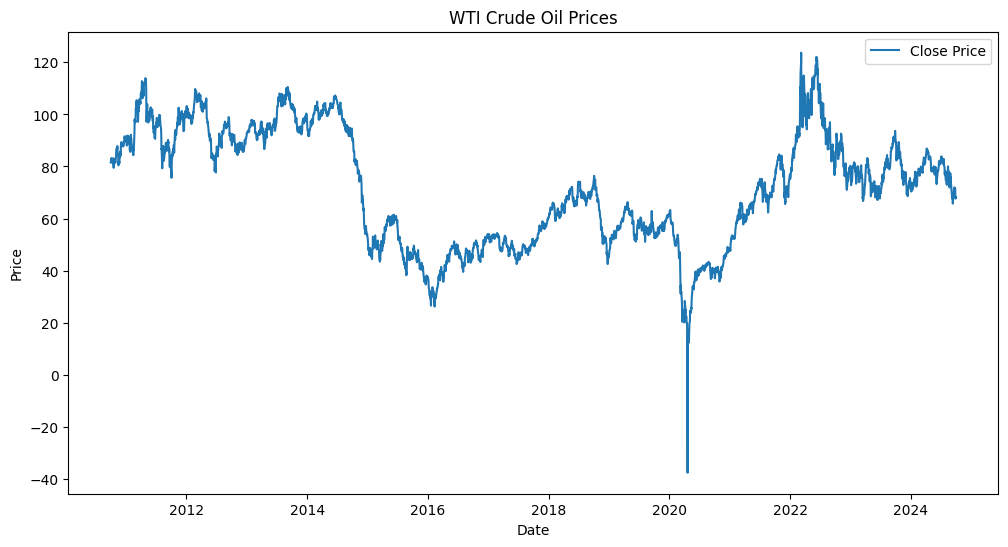

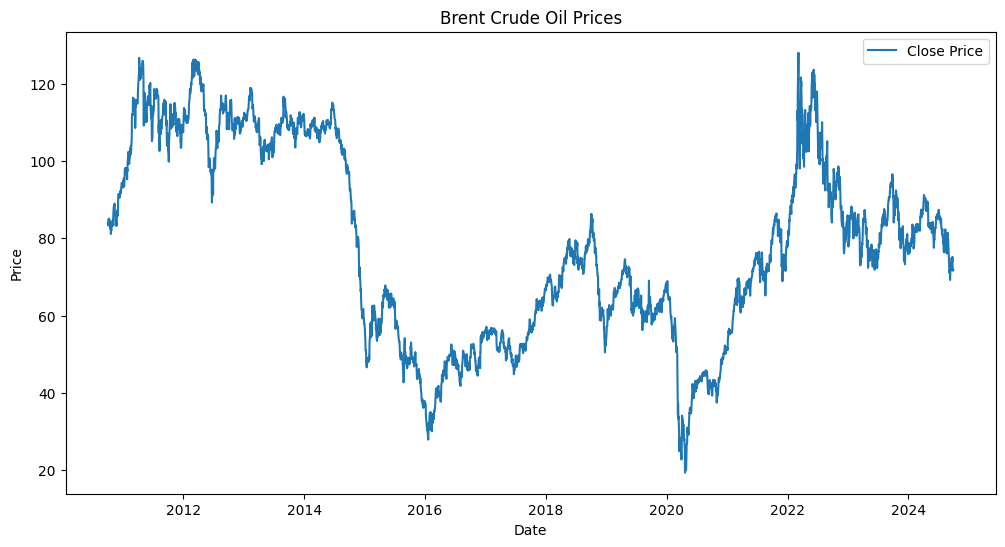

In [14]:
plot_time_series(wti_clean, column='Close', title='WTI Crude Oil Prices')
plot_time_series(brent_clean, column='Close', title='Brent Crude Oil Prices')


# Step 3: Comparison Analysis

Summary Statistics:               Open         High          Low        Close    Adj Close  \
count  3520.000000  3520.000000  3520.000000  3520.000000  3520.000000   
mean     71.755770    72.810270    70.598290    71.724128    71.724128   
std      22.009125    22.130264    21.874608    22.042015    22.042015   
min     -14.000000    13.690000   -40.320000   -37.630001   -37.630001   
25%      52.557501    53.382500    51.744999    52.577501    52.577501   
50%      72.064999    73.079998    71.000000    72.000000    72.000000   
75%      91.152502    92.232500    90.000000    91.170002    91.170002   
max     124.660004   130.500000   120.790001   123.699997   123.699997   

             Volume  
count  3.520000e+03  
mean   4.073644e+05  
std    2.073654e+05  
min    0.000000e+00  
25%    2.659982e+05  
50%    3.528965e+05  
75%    5.273685e+05  
max    2.288230e+06  
Summary Statistics:               Open         High          Low        Close    Adj Close  \
count  3491.000000  3

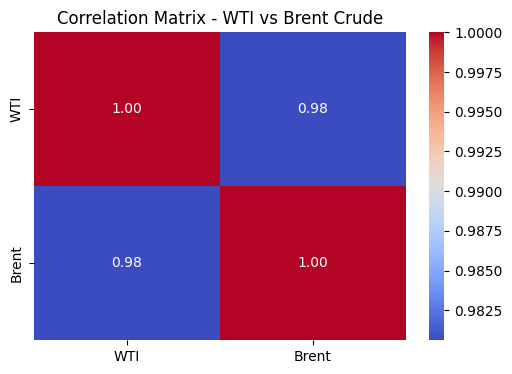

ADF Statistic: -2.059364014728914
p-value: 0.2611651825485508
Critical Values: 1%, -3.4322112288397735
Critical Values: 5%, -2.8623623855085953
Critical Values: 10%, -2.5672077698860143
ADF Statistic: -1.7554567885583892
p-value: 0.40278945294675383
Critical Values: 1%, -3.432227797183076
Critical Values: 5%, -2.8623697039362583
Critical Values: 10%, -2.5672116660045408


0.40278945294675383

In [15]:
# Descriptive Statistics
wti_stats = generate_summary_statistics(wti_clean)
brent_stats = generate_summary_statistics(brent_clean)

# Correlation Analysis
perform_correlation_analysis(wti_clean, brent_clean)

# Test Stationarity
test_stationarity(wti_clean, 'Close')
test_stationarity(brent_clean, 'Close')

# Step 4: Fit ARIMA AND GARCH MODEL

Best ARIMA order: (1, 1, 1) with AIC: 14723.645546423173
Best ARIMA order: (2, 1, 2) with AIC: 13128.09454555047
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3520
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7358.823
Date:                Wed, 02 Oct 2024   AIC                          14723.646
Time:                        07:43:52   BIC                          14742.143
Sample:                             0   HQIC                         14730.245
                               - 3520                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1912      0.032      6.005      0.000       0.129       0.254
ma.L1         -0.3

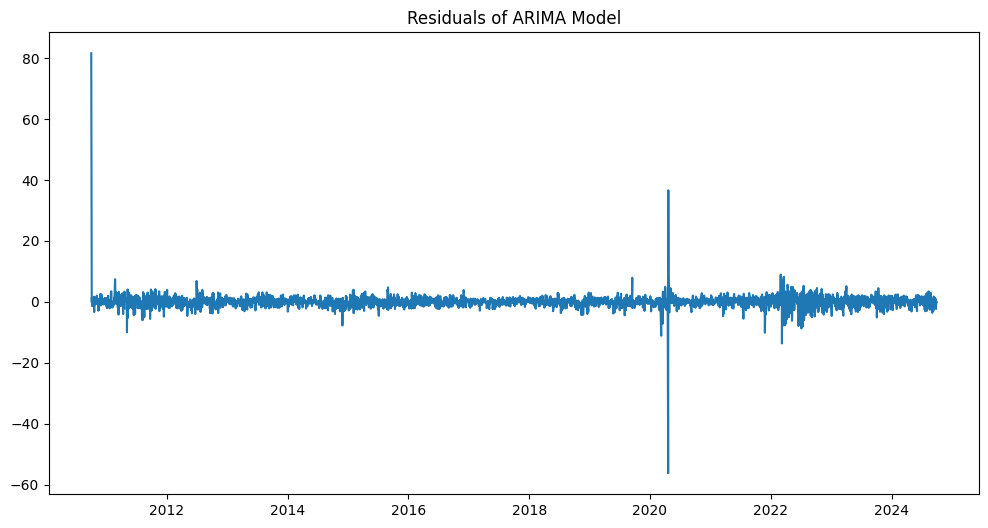

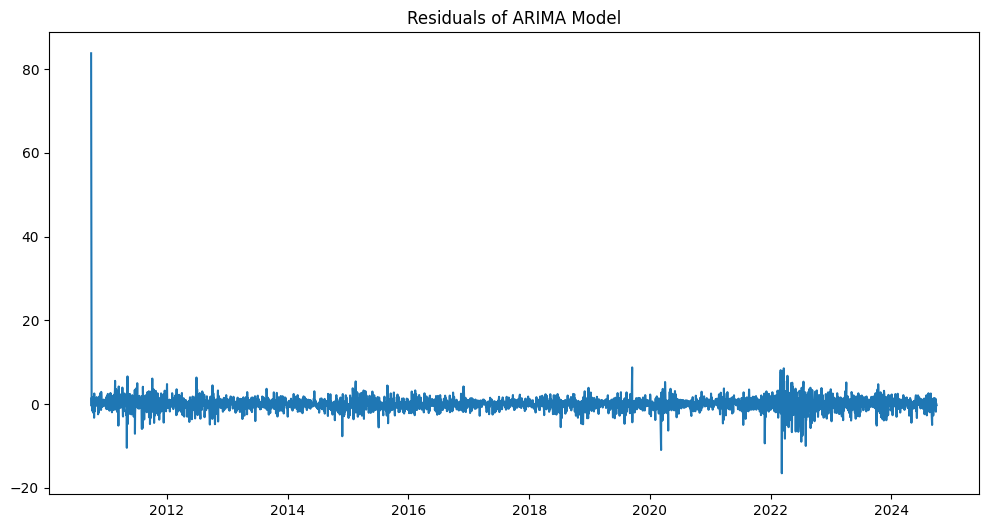

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14517.3
Distribution:                  Normal   AIC:                           29042.6
Method:            Maximum Likelihood   BIC:                           29067.2
                                        No. Observations:                 3520
Date:                Wed, Oct 02 2024   Df Residuals:                     3519
Time:                        07:43:58   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            71.2744      0.510    139.804      0.000 [ 70.275, 72.27

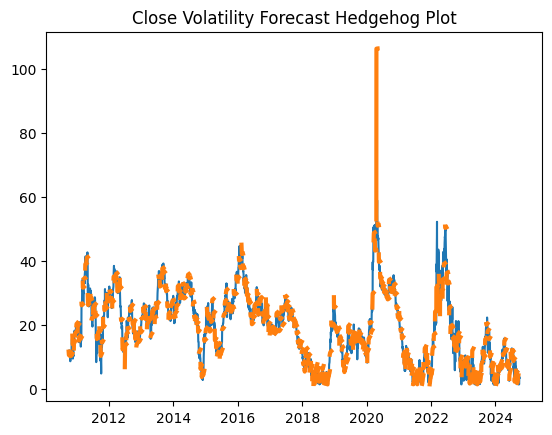

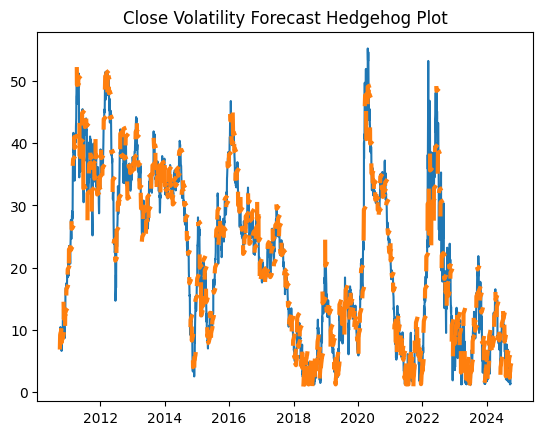

In [16]:
# Optimize and Fit ARIMA Model
best_order_wti = optimize_arima_params(wti_clean)
best_order_brent = optimize_arima_params(brent_clean)

wti_arima_model = fit_arima_model(wti_clean, order=best_order_wti)
brent_arima_model = fit_arima_model(brent_clean, order=best_order_brent)

# Analyze ARIMA Residuals
wti_residuals = analyze_residuals(wti_arima_model)
brent_residuals = analyze_residuals(brent_arima_model)

# Fit GARCH Model for Volatility Analysis
wti_garch_model = fit_garch_model(wti_clean)
brent_garch_model = fit_garch_model(brent_clean)

# Validate GARCH Model
wti_garch_test = validate_garch_model(wti_garch_model)
brent_garch_test = validate_garch_model(brent_garch_model)


STEP 5: COMPARISON BETWEEN WTI AND BRENT

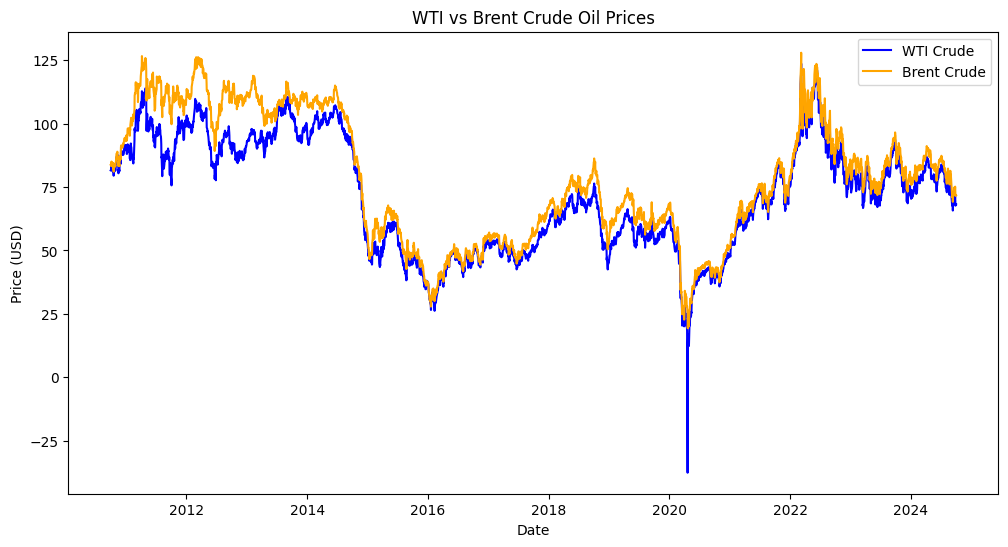


Correlation between WTI and Brent Crude:
            WTI     Brent
WTI    1.000000  0.980607
Brent  0.980607  1.000000


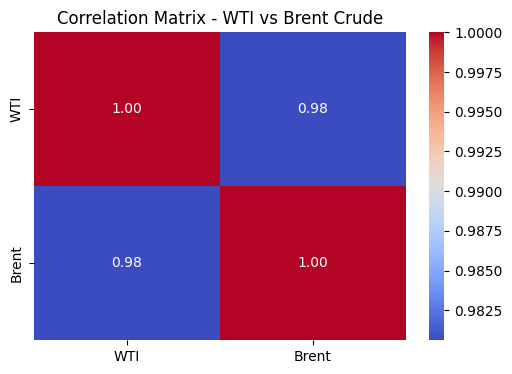

In [17]:
# 1. Plot comparison of WTI and Brent Crude Prices
plot_comparison(wti_clean, brent_clean)

# 2. Perform Correlation Analysis between WTI and Brent
perform_correlation_analysis(wti_clean, brent_clean)

STEP 6:PREDICT FUTURE PRICES FOR WTI AND BRENT CRUDE

WTI Crude Price Forecast:


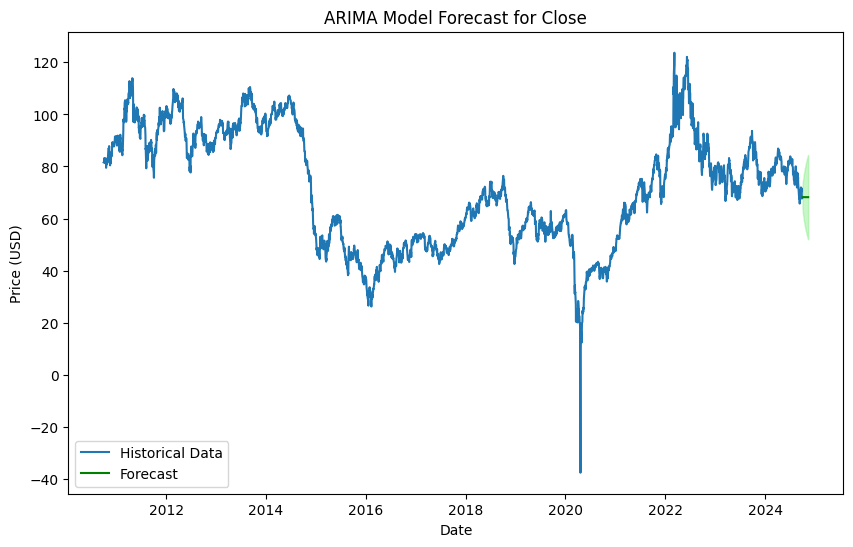


Brent Crude Price Forecast:


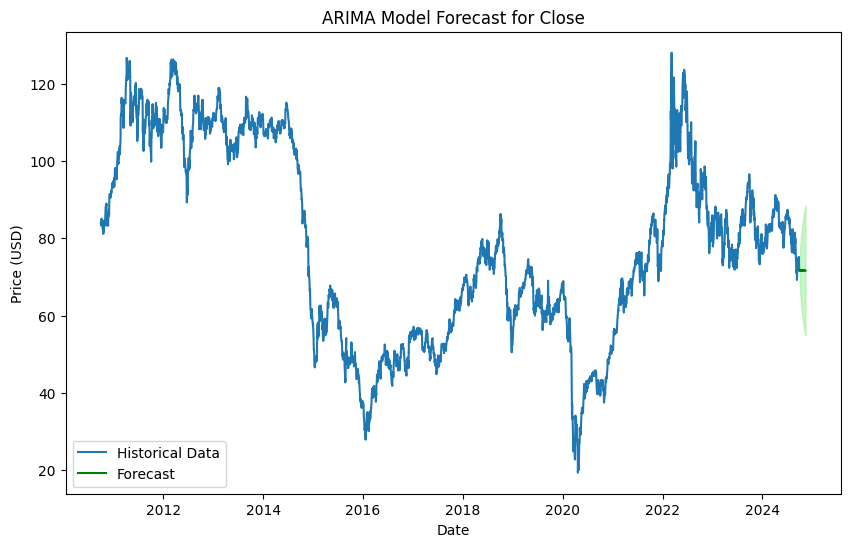

In [33]:
# Predict future prices for WTI and Brent Crude for the next 30 days
print("WTI Crude Price Forecast:")
wti_forecast = fit_and_predict_arima(wti_clean, best_order_wti)

print("\nBrent Crude Price Forecast:")
brent_forecast = fit_and_predict_arima(brent_clean, best_order_brent)